In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

In [2]:
def compute_cm(cm):
    arr = np.array(cm)
    arr = arr.astype('float') / arr.sum(axis=(2), keepdims=True)
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    return arr_mean, arr_std

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, )
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def normalize_data(X1, X2):
    """
    Expects data in shape (n_samples, channels, z, y, x)
    """
    X1_ = X1.copy()
    X1_norm = (X1_ - X1_.mean(axis=(0, 2, 3, 4), keepdims=True)) / X1_.std(axis=(0, 2, 3, 4), keepdims=True)
    
    X2_ = X2.copy()
    X2_norm = (X2_ - X2_.mean(axis=(0, 2, 3, 4), keepdims=True)) / X2_.std(axis=(0, 2, 3, 4), keepdims=True)

    return X1_norm, X2_norm

In [76]:
mask_11 = np.load('./11_11_11_edge_mask.npy')
mask_11 = mask_11 == False

mask_15 = np.load('./15_9_9_edge_mask.npy')
mask_15 = mask_15 == False

In [42]:
data = np.load('data.npy')
df = pd.read_csv('./Site3Synaptograms.csv')

In [43]:
X = data.copy()
y = df['GABA'].values

In [78]:
data = np.load('./data_isotropic.npy')
X = data.copy()

In [44]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.99729167 0.00270833]
 [0.83224638 0.16775362]]


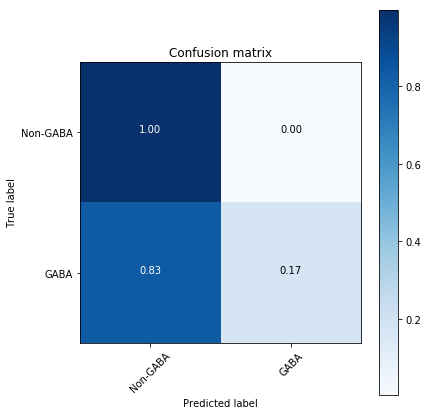

In [45]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

### PCA without Normalization

In [18]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    #X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA()
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.99875    0.00125   ]
 [0.96630435 0.03369565]]


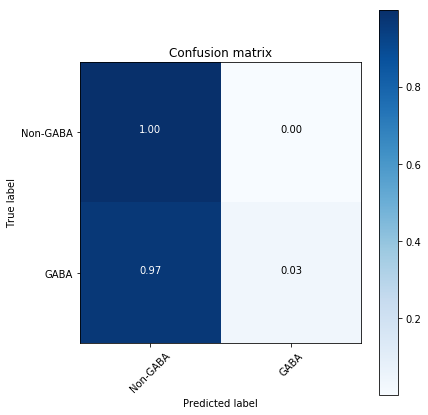

In [22]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

### PCA with data normalization
Normalization is subtract mean and divide by std for each channel

In [23]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA()
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.99645833 0.00354167]
 [0.9165942  0.0834058 ]]


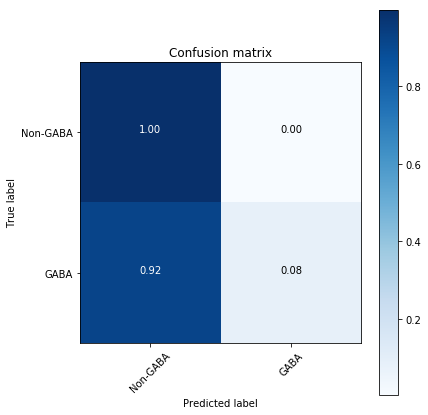

In [24]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

PCA with mean subtractions

In [25]:
def subtract_mean(X1, X2):
    X1_ = X1.copy()
    X1_norm = (X1_ - X1_.mean(axis=(0, 2, 3, 4), keepdims=True))
    
    X2_ = X2.copy()
    X2_norm = (X2_ - X2_.mean(axis=(0, 2, 3, 4), keepdims=True))

    return X1_norm, X2_norm

In [29]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    #X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    X_train, X_test = subtract_mean(X[train_idx], X[test_idx])
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA(whiten=True)
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[9.99166667e-01 8.33333333e-04]
 [9.69202899e-01 3.07971014e-02]]


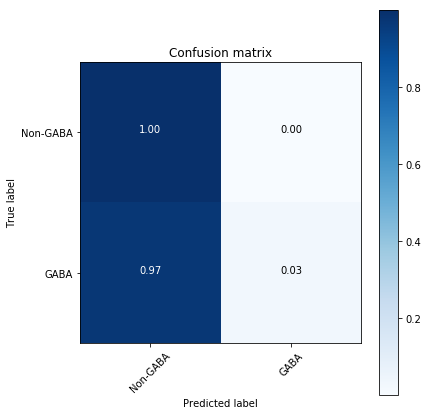

In [30]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

### PCA with normalization and non-edge synapses

In [81]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []
X_ = X[mask_15]
y_ = y[mask_15]

for train_idx, test_idx in kfold.split(X_, y_):
    y_train, y_test = y_[train_idx], y_[test_idx]
    X_train, X_test = normalize_data(X_[train_idx], X_[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    #X_train, X_test = subtract_mean(X[train_idx], X[test_idx])
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA(whiten=True)
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.9958372  0.0041628 ]
 [0.91818182 0.08181818]]


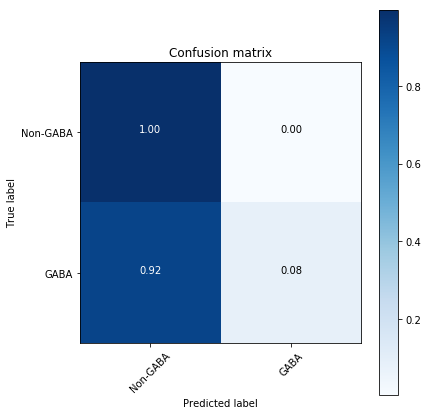

In [82]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

## Shaft vs Non-shaft

In [83]:
data = np.load('data_isotropic.npy')
df = pd.read_csv('./Site3Synaptograms.csv')

X = data.copy()
y = df['GABA'].values

In [84]:
X = X[mask_15]
y = y[mask_15]

In [85]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    #X_train, X_test = subtract_mean(X[train_idx], X[test_idx])
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA(whiten=True)
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced_subsample')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.99755499 0.00244501]
 [0.93454545 0.06545455]]


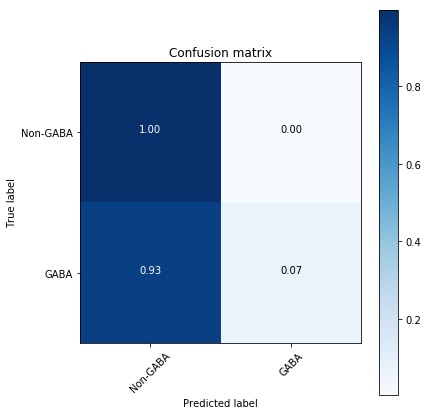

In [86]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

In [87]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    #p = PCA()
    #p.fit(X_train)
    #features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    #X_train = p.transform(X_train)[:, :features]
    #X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.9968173  0.0031827 ]
 [0.81636364 0.18363636]]


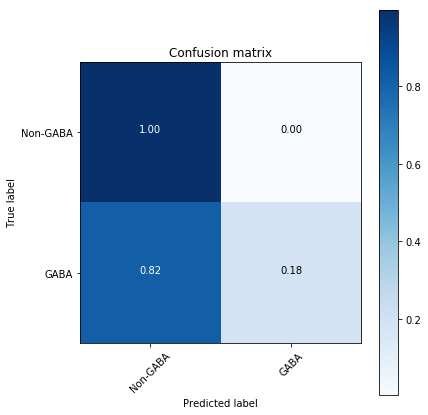

In [88]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

In [92]:
df = pd.read_csv('./MNSite3Synaptograms.csv', index_col = 0, header=1)

In [93]:
df.head()

,Nz,figure,height,id,maxX,maxY,maxZ,minX,minY,minZ,...,shaft,NotSynapse,nofigure,edgesynapse,enface synapse,PSD positive,comments FC,comments MN,Unnamed: 24,Unnamed: 25
0,10,/nas3/data/M247514_Rorb_1/processed/Site3Synap...,419.0,0,7131.0,6734.0,35,6766.0,6316.0,25,...,0,0,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,6,/nas3/data/M247514_Rorb_1/processed/Site3Synap...,376.0,1,7535.0,5923.0,49,7171.0,5548.0,43,...,0,0,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,5,/nas3/data/M247514_Rorb_1/processed/Site3Synap...,399.7,2,7579.6,7233.1,4,7258.4,6834.4,-1,...,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1786.3,3,8470.7,7422.7,6,7349.0,5637.4,2,...,0,1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,/nas3/data/M247514_Rorb_1/processed/Site3Synap...,330.0,4,7657.0,5911.0,45,7289.0,5582.0,39,...,1,0,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [94]:
shaft = df['shaft'].values
shaft = shaft[mask_15]

In [95]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, shaft):
    y_train, y_test = shaft[train_idx], shaft[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    #p = PCA()
    #p.fit(X_train)
    #features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    #X_train = p.transform(X_train)[:, :features]
    #X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.94633125 0.05366875]
 [0.88323232 0.11676768]]


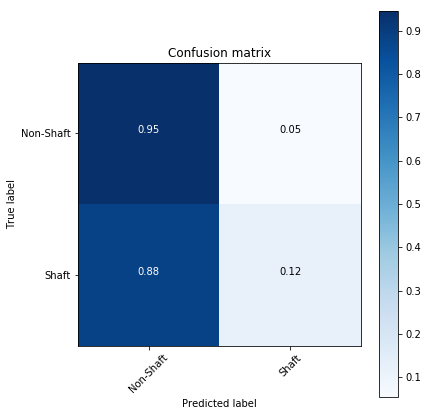

In [96]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-Shaft', 'Shaft'])
plt.show()

In [99]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, shaft):
    y_train, y_test = shaft[train_idx], shaft[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    #X_train, X_test = subtract_mean(X[train_idx], X[test_idx])
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA()
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.8978811  0.1021189 ]
 [0.84215488 0.15784512]]


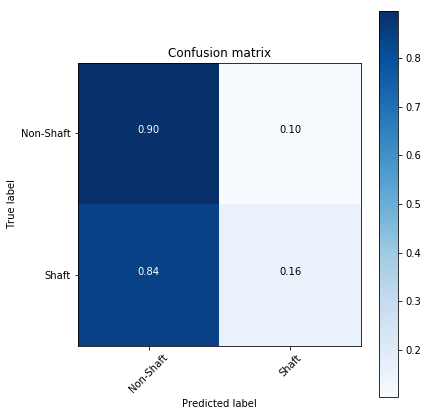

In [100]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-Shaft', 'Shaft'])
plt.show()

In [ ]:
multi_class = np.zeros(len(y))

a = (y == 0) * (shaft == 0)
b = (y == 0) * (shaft == 1)
c = (y == 1) * (shaft == 0)
d = (y == 1) * (shaft == 1)

multi_class[b] = 1
multi_class[c] = 2
multi_class[d] = 3

In [134]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, multi_class):
    y_train, y_test = multi_class[train_idx], multi_class[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    #p = PCA()
    #p.fit(X_train)
    #features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    #X_train = p.transform(X_train)[:, :features]
    #X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[0.96398374 0.03374771 0.         0.00226855]
 [0.92339024 0.06765854 0.001      0.00795122]
 [0.775      0.065      0.025      0.135     ]
 [0.73428571 0.06       0.02571429 0.18      ]]


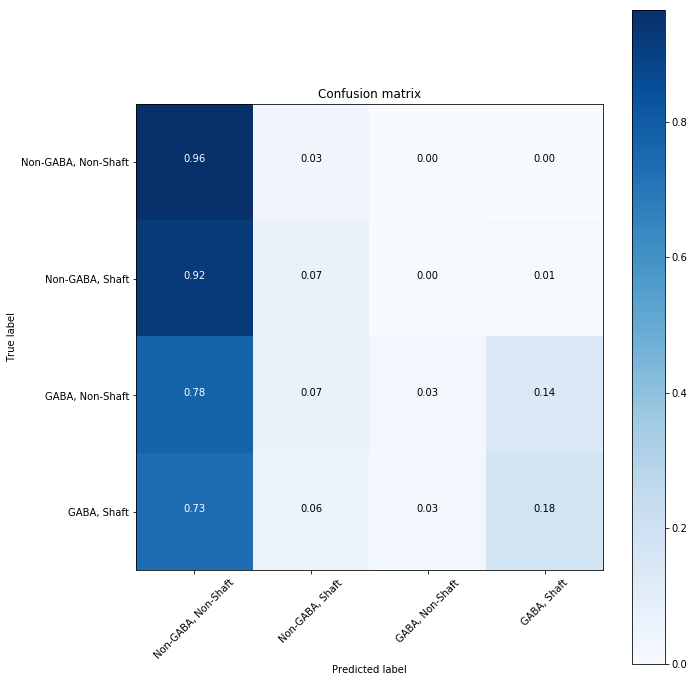

In [136]:
mu, std = compute_cm(cm)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(mu, ['Non-GABA, Non-Shaft', 'Non-GABA, Shaft', 'GABA, Non-Shaft', 'GABA, Shaft'])
plt.show()

In [139]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = []

for train_idx, test_idx in kfold.split(X, multi_class):
    y_train, y_test = multi_class[train_idx], multi_class[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    #X_train, X_test = X[train_idx], X[test_idx]
    #X_train, X_test = subtract_mean(X[train_idx], X[test_idx])
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    p = PCA()
    p.fit(X_train)
    features = (p.explained_variance_ratio_.cumsum() <= 0.9).sum()
    X_train = p.transform(X_train)[:, :features]
    X_test = p.transform(X_test)[:, :features]
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred))

Confusion matrix, without normalization
[[8.96430632e-01 1.01620771e-01 3.22580645e-04 1.62601626e-03]
 [8.64707317e-01 1.32292683e-01 1.00000000e-03 2.00000000e-03]
 [8.95000000e-01 6.00000000e-02 0.00000000e+00 4.50000000e-02]
 [8.88571429e-01 5.71428571e-02 0.00000000e+00 5.42857143e-02]]


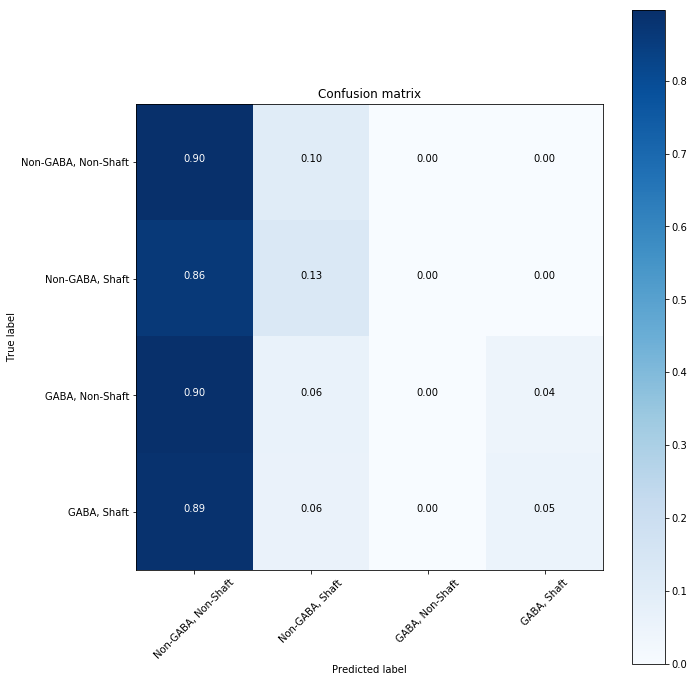

In [140]:
mu, std = compute_cm(cm)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(mu, ['Non-GABA, Non-Shaft', 'Non-GABA, Shaft', 'GABA, Non-Shaft', 'GABA, Shaft'])
plt.show()

In [151]:
p.components_.shape

(742, 9720)

In [145]:
X_train

array([[  7.41315813,  -5.91117251,  -7.85993192, ...,  -5.1169115 ,
          0.39326956,   1.33151457],
       [ -5.75960864, -10.12976984,  11.74921551, ...,  -1.0782855 ,
         -1.54433681,   1.9094781 ],
       [ -6.39712218,  -5.58399366,   2.9325006 , ...,   3.36702153,
         -1.67660749,   0.09645794],
       ...,
       [ -1.18444704, -14.75289779,   1.37564656, ...,  -5.90651815,
          0.08616565,   5.64124794],
       [  9.70615449, -10.8319555 , -25.60455836, ...,   1.87686198,
          4.38881652,  -0.91639721],
       [ -3.47157431,  -6.61605701,   2.64473242, ...,  -0.15204347,
          1.00173452,  -0.49553963]])

In [144]:
X_train.shape

(742, 456)

In [153]:
a.sum()

616

In [154]:
b.sum()

201

In [155]:
c.sum()

40

In [156]:
d.sum()

70

In [158]:
y.sum()

110